In [1]:
import pdb
from math import log10, floor

import numpy as np
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
import radvel

from analysis_scripts import sval_correlations

%matplotlib inline

## Load entirety of Legacy catalog dataset.

In [2]:
data_all = pd.read_csv('../rvdata/legacy_all_data.csv')

In [6]:
data_all.psf3

0         0
1         0
2         0
3         0
4         0
         ..
104712    0
104713    0
104714    0
104715    0
104716    0
Name: psf3, Length: 104717, dtype: int64

In [3]:
data.query('tel == "j"').sval

18        0.1620
19        0.1630
20        0.1620
21        0.1620
22        0.1630
           ...  
103986    0.1450
103987    0.1450
103988    0.1487
103989    0.1454
103990       NaN
Name: sval, Length: 48712, dtype: float64

## Query for data associated with star of interest, in this case 177830.

In [40]:
data_ours = data.query('name == "177830"').reset_index()

In [41]:
data_ours.bc

0        784.911987
1        648.963989
2      11966.449219
3      -7495.011230
4       8565.545898
           ...     
275   -18550.306641
276   -18767.542969
277   -19732.539062
278   -19786.996094
279   -19901.263672
Name: bc, Length: 280, dtype: float64

### Load two-planet model.

In [30]:
post = radvel.posterior.load('../rvdata/177830/post_final.pkl')

In [31]:
data_hires = data_ours.query('tel == "j" or tel == "k"').reset_index()
data_apf   = data_ours.query('tel == "apf"').reset_index()

In [16]:
rvs_to_play_hires = np.array(data_hires.mnvel)
rvs_to_play_apf   = np.array(data_apf.mnvel)
bcs_hires         = np.array(data_hires.bc)
bcs_apf           = np.array(data_apf.bc)
svals_apf         = np.array(data_apf.sval)

In [17]:
orbel = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
mod_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel)
mod_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel)
rvs_to_play_hires -= mod_hires
rvs_to_play_apf   -= mod_apf

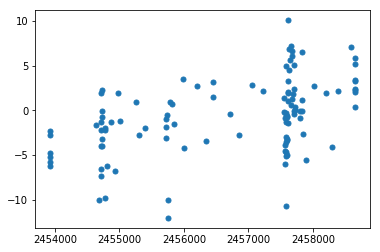

In [18]:
fig, ax = plt.subplots()
ax.scatter(data_hires.jd, rvs_to_play_hires)

Text(0, 0.5, 'RV (m/s)')

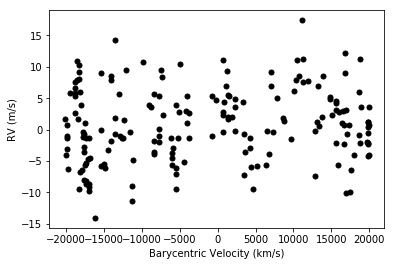

In [47]:
fig, ax = plt.subplots()
ax.scatter(bcs_hires, rvs_to_play_hires, c='black')
ax.set_xlabel('Barycentric Velocity (km/s)')
ax.set_ylabel('RV (m/s)')

Text(0, 0.5, 'RV (m/s)')

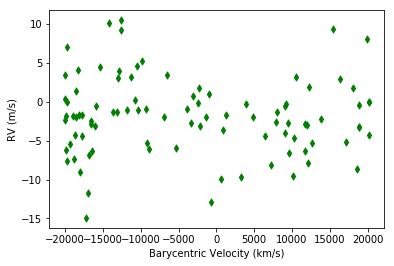

In [48]:
fig, ax = plt.subplots()
ax.scatter(bcs_apf, rvs_to_play_apf, c='green', marker='d')
ax.set_xlabel('Barycentric Velocity (km/s)')
ax.set_ylabel('RV (m/s)')

## Do the same for 168009.

In [5]:
data_ours = data.query('name == "168009"').reset_index()
post = radvel.posterior.load('../rvdata/168009/post_final.pkl')

In [6]:
data_hires = data_ours.query('tel == "j"').reset_index()
data_apf   = data_ours.query('tel == "apf"').reset_index()

In [7]:
rvs_to_play_hires = np.array(data_hires.mnvel)
rvs_to_play_apf   = np.array(data_apf.mnvel)
bcs_hires         = np.array(data_hires.bc)
bcs_apf           = np.array(data_apf.bc)
svals_hires       = np.array(data_hires.SVAL)
svals_apf         = np.array(data_apf.SVAL)

In [8]:
orbel = [post.params['per2'].value,
         post.params['tp2'].value,
         post.params['e2'].value,
         post.params['w2'].value,
         post.params['k2'].value]
mod_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel)
mod_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel)
rvs_to_play_hires -= mod_hires
rvs_to_play_apf   -= mod_apf

Text(0, 0.5, 'RV (m/s)')

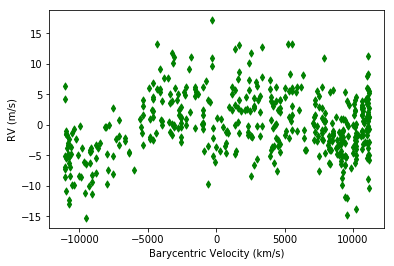

In [10]:
fig, ax = plt.subplots()
ax.scatter(bcs_apf, rvs_to_play_apf, c='green', marker='d')
ax.set_xlabel('Barycentric Velocity (km/s)')
ax.set_ylabel('RV (m/s)')

## De-trend from activity.

In [15]:
data_ours.query('tel == "j"').sval

0      0.1560
1      0.1560
2      0.1560
3      0.1560
4      0.1560
        ...  
105    0.0000
106    0.1597
107    0.1601
108    0.1605
109    0.1601
Name: sval, Length: 110, dtype: float64

(0.12, 0.16)

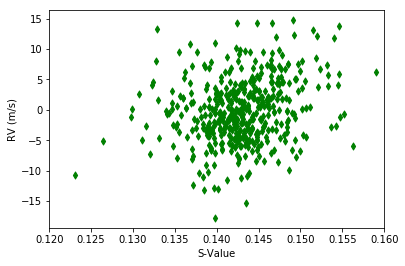

In [84]:
fig, ax = plt.subplots()
ax.scatter(svals_apf, rvs_to_play_apf, c='green', marker='d')
ax.set_xlabel('S-Value')
ax.set_ylabel('RV (m/s)')
ax.set_xlim([0.12, 0.16])

## Make S-value periodograms for long-period candidates.

In [1]:
svals = data.query('name == "24040" and sval > 0.146').sval
times = data.query('name == "24040" and sval > 0.146').jd

frequency, power = LombScargle(times, svals).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple')#, label='S-value periodogram')
ax.axvline(1/frequency[np.argmax(power)], ls='--', 
           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 24040 Activity')

fig.savefig('validation_plots/activity_24040.pdf')

NameError: name 'data' is not defined

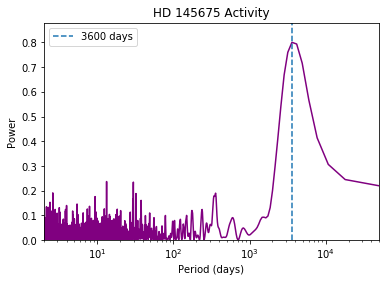

In [59]:
svals = data.query('name == "145675" and sval > 0.12').sval
times = data.query('name == "145675" and sval > 0.12').jd

frequency, power = LombScargle(times, svals).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple')#, label='S-value periodogram')
ax.axvline(1/frequency[np.argmax(power)], ls='--', 
           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 145675 Activity')

fig.savefig('validation_plots/activity_145675.pdf')

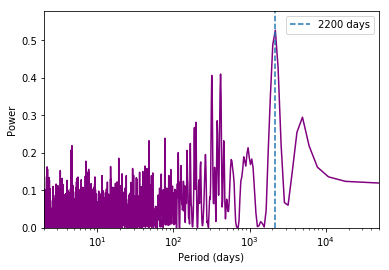

In [4]:
svals = data.query('name == "107148" and sval < 0.17 and sval > 0.15').sval
times = data.query('name == "107148" and sval < 0.17 and sval > 0.15').jd

frequency, power = LombScargle(times, svals).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple')#, label='S-value periodogram')
ax.axvline(1/frequency[np.argmax(power)], ls='--', 
           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 145675 Activity')

fig.savefig('validation_plots/activity_107148.pdf')

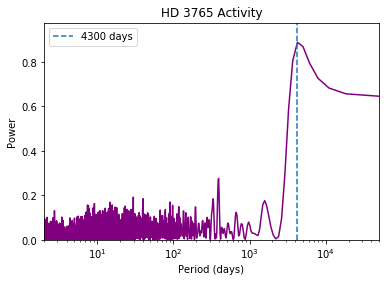

In [66]:
svals = data.query('name == "3765" and sval > 0.12').sval
times = data.query('name == "3765" and sval > 0.12').jd

frequency, power = LombScargle(times, svals).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple')#, label='S-value periodogram')
ax.axvline(1/frequency[np.argmax(power)], ls='--', 
           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 3765 Activity')#, fontname='Times New Roman')

fig.savefig('validation_plots/activity_3765.pdf')

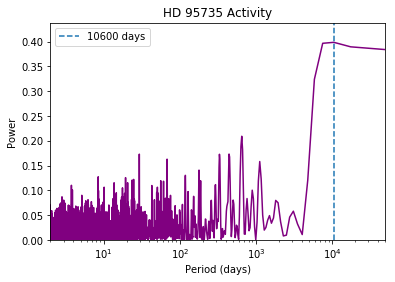

In [55]:
svals = data.query('name == "95735" and sval < 0.8').sval
times = data.query('name == "95735" and sval < 0.8').jd

frequency, power = LombScargle(times, svals).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple')#, label='S-value periodogram')
ax.axvline(1/frequency[np.argmax(power)], ls='--', 
           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 95735 Activity')

fig.savefig('validation_plots/activity_95735.pdf')

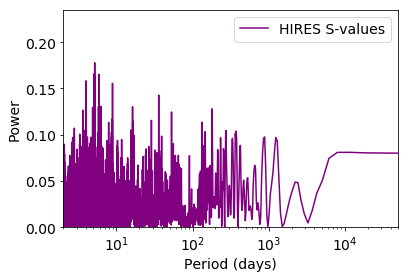

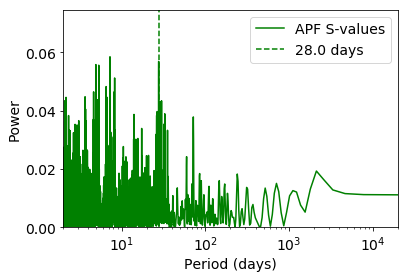

In [20]:
data8 = pd.read_csv('../rvdata/vst86728.csv')
matplotlib.rcParams.update({'font.size': 14})

svals_j = data8.query('tel == "j" and svalue > 0.13').svalue
times_j = data8.query('tel == "j" and svalue > 0.13').jd

svals_a = data8.query('tel == "apf"').svalue
times_a = data8.query('tel == "apf"').jd

frequency, power = LombScargle(times_j, svals_j).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple', label='HIRES S-values')
#ax.axvline(1/frequency[np.argmax(power)], ls='--', 
#           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 86728 Activity')
fig.savefig('validation_plots/activity_86728_HIRES.pdf')


frequency, power = LombScargle(times_a, svals_a).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='green', label='APF S-values')
ax.axvline(28, ls='--', color='green', label='28.0 days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 2*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 86728 Activity')
fig.savefig('validation_plots/activity_86728_APF.pdf')

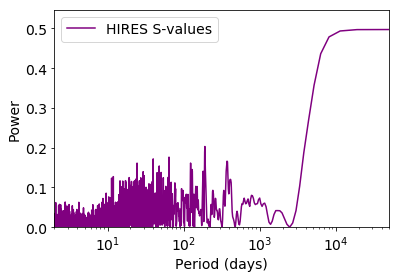

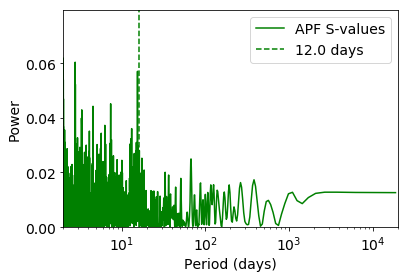

In [26]:
data1 = pd.read_csv('../rvdata/vst164922.csv')
matplotlib.rcParams.update({'font.size': 14})

svals_j = data1.query('tel == "j" and svalue > 0.148').svalue
times_j = data1.query('tel == "j" and svalue > 0.148').jd

svals_a = data1.query('tel == "apf" and svalue > 0.12').svalue
times_a = data1.query('tel == "apf" and svalue > 0.12').jd
#print(svals_a)

frequency, power = LombScargle(times_j, svals_j).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='purple', label='HIRES S-values')
#ax.axvline(1/frequency[np.argmax(power)], ls='--', 
#           label=str(round(1/frequency[np.argmax(power)], -2))[:-2] + ' days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 5*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 86728 Activity')
fig.savefig('validation_plots/activity_164922_HIRES.pdf')


frequency, power = LombScargle(times_a, svals_a).autopower(nyquist_factor=100)

fig, ax = plt.subplots()
ax.plot(1/frequency, power, c='green', label='APF S-values')
ax.axvline(16, ls='--', color='green', label='12.0 days')
ax.legend()

ax.set_xscale('log')
ax.set_xlim([2, 2*10**4])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
#ax.set_title('HD 86728 Activity')
fig.savefig('validation_plots/activity_164922_APF.pdf')

## HD 192310. Known planets at 74 and 525 days, 2nd may be activity.

In [12]:
data = pd.read_csv('../rvdata/vst192310.csv')
post = radvel.posterior.load('special_systems/192310/post_final.pkl')

data = data.query('svalue > 0.14')

svals = {}
#svals['k'] = data.query('tel == "k"').svalue
svals['j'] = data.query('tel == "j"').svalue
#svals['apf'] = data.query('tel == "apf"').svalue

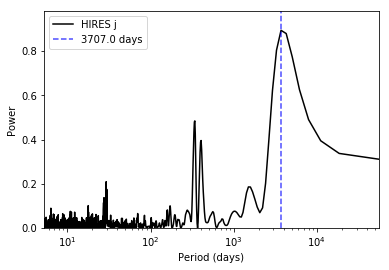

In [13]:
frequency, power = LombScargle(data.query('tel == "j"').jd, svals['j']).autopower()

fig, ax = plt.subplots()
#ax.set_title('HD 1457675 S-value periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')

ax.set_xlim([np.amin(1/frequency), np.amax(1/frequency)])
ax.set_ylim([0, 1.1*np.amax(power)])
ax.set_xscale('log')

ax.plot(1/frequency, power, c='black', label='HIRES j')
ax.axvline(1/frequency[np.argmax(power)], ls='--', c='blue', 
           alpha=0.7, label='{} days'.format(np.round(1/frequency[np.argmax(power)], decimals=0)))
ax.legend()
fig.savefig('special_systems/192310/sval_periodogram.png', dpi=500)

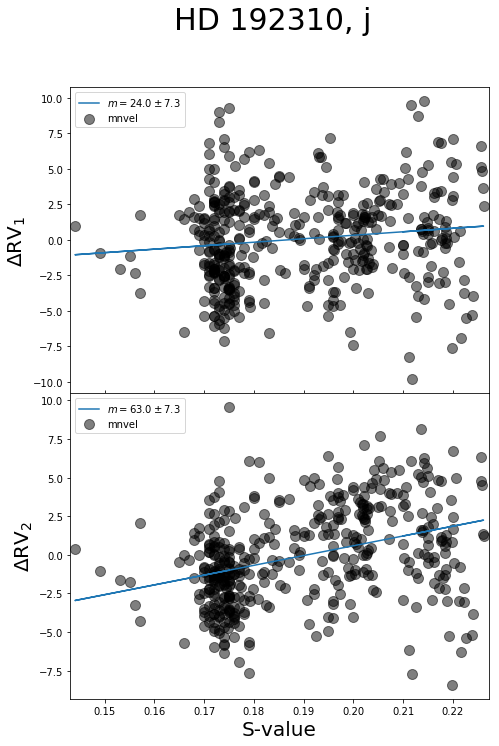

In [14]:
correlator = sval_correlations.Correlator(post, svals, data=data, starname='HD 192310')
correlator.make_all_residuals()

for i in [1, 2]:
    correlator.correlate('j', i)
    #correlator.correlate('apf', i)

correlator.stack_one_tel('j')
#correlator.stack_one_tel('apf')

## HD 115617. 3 Known planets, outer is 122 days. Two RVSearch peaks of equal height at ~91 and ~122 days, yearly systematics suspected.

In [94]:
#data = pd.read_csv('../rvdata/vst115617.csv').query('cts > 3000')
data = data_all.query('name == "115617" and cts > 3000').reset_index(drop=True)
data_hires = data.query('tel == "j"')# and svalue < 0.175 and svalue > 0.16').reset_index() # svalue for individual file
data_apf   = data.query('tel == "apf"').reset_index()
post = radvel.posterior.load('special_systems/192310/post_final.pkl')

rvs_hires   = np.array(data_hires.mnvel)
rvs_apf     = np.array(data_apf.mnvel)
bcs_hires   = np.array(data_hires.bc)
bcs_apf     = np.array(data_apf.bc)
svals_hires = np.array(data_hires.SVAL) # svalue for individual set
svals_apf   = np.array(data_apf.SVAL)
chis_hires  = np.array(data_hires.mdchi)
chis_apf    = np.array(data_apf.mdchi)

orbel1 = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
orbel2 = [post.params['per2'].value,
         post.params['tp2'].value,
         post.params['e2'].value,
         post.params['w2'].value,
         post.params['k2'].value]

mod1_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel1)
mod1_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel1)
mod2_hires = radvel.kepler.rv_drive(np.array(data_hires.jd), orbel2)
mod2_apf   = radvel.kepler.rv_drive(np.array(data_apf.jd), orbel2)
rvs_hires -= mod1_hires + mod2_hires
rvs_apf   -= mod1_apf + mod2_apf

In [95]:
data.columns

Index(['Unnamed: 0', 'JD_UTC', 'OBSNM', 'Prot', 'S-value', 'S/N', 'SVAL',
       'age', 'bc', 'comment', 'cts', 'date', 'date_sval', 'day', 'day_sval',
       'decker', 'dewar', 'errvel', 'gain', 'hjd_utc', 'hjd_utc_sval', 'inst',
       'iodnm', 'jd', 'jd_sval', 'jitter', 'kjd', 'kjd_sval', 'mdchi', 'mdpar',
       'mdvel', 'med_all', 'mnpar', 'mnvel', 'name', 'nchunk', 'obnm', 'obs',
       'phase', 'psfpix', 'psfsig', 'rphk', 'sn', 'sp1', 'sp2', 'spst', 'star',
       'sval', 'tel', 'z'],
      dtype='object')

In [110]:
print(data_hires.mnpar[0])
#print(np.fromstring(data_hires.mnpar[0], count=20, sep = '  '))

[ 1.0000000e+00  0.0000000e+00  1.4038940e-02 -3.8239085e-03
  9.4216332e-02  2.0627961e-01  1.5183707e-01  2.6742389e-02
 -5.8111460e-03  1.3091555e-01  2.2708005e-01  4.8665485e-01
 -1.8698242e-04  2.4494253e-02  0.0000000e+00  1.5460642e-01
 -1.1222875e-02  1.4996667e-02  0.0000000e+00  0.0000000e+00]


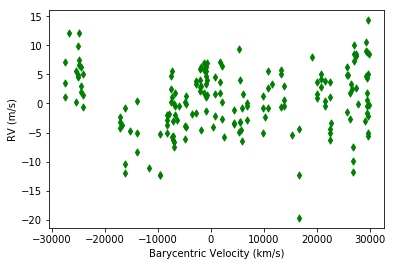

In [83]:
fig, ax = plt.subplots()
ax.scatter(bcs_apf, rvs_apf, c='green', marker='d')
ax.set_xlabel('Barycentric Velocity (km/s)')
ax.set_ylabel('RV (m/s)')
fig.savefig('special_systems/115617/bcs_rvs_apf.png', dpi=200)

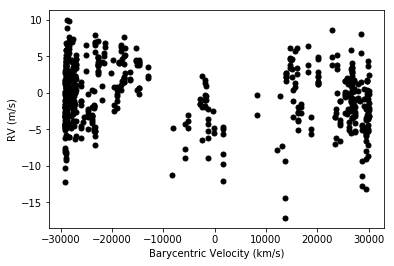

In [82]:
fig, ax = plt.subplots()
ax.scatter(bcs_hires, rvs_hires, c='black', marker='o')
ax.set_xlabel('Barycentric Velocity (km/s)')
ax.set_ylabel('RV (m/s)')
fig.savefig('special_systems/115617/bcs_rvs_hires.png', dpi=200)